Imports & Environment Setup

In [23]:
# Import required libraries for model building, data handling, and visualization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import gdown
import seaborn as sns

print(f"Using TensorFlow Version: {tf.__version__}")

# Check for available GPU devices to optimize training performance
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU is available: {gpu_devices}")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("GPU not available, training will be on CPU.")

Using TensorFlow Version: 2.7.0
GPU not available, training will be on CPU.


Data Loading & Initial Exploration

In [24]:
# Define the dataset directory
DATA_DIR = 'dataset'

# Verify that the dataset directory exists
if not os.path.exists(DATA_DIR):
    print("Dataset directory not found. Please ensure 'Animals-15' is in the correct path.")
else:
    # List class names and count the number of classes
    class_names = sorted(os.listdir(DATA_DIR))
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")

Found 15 classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']


Visualize Sample Images

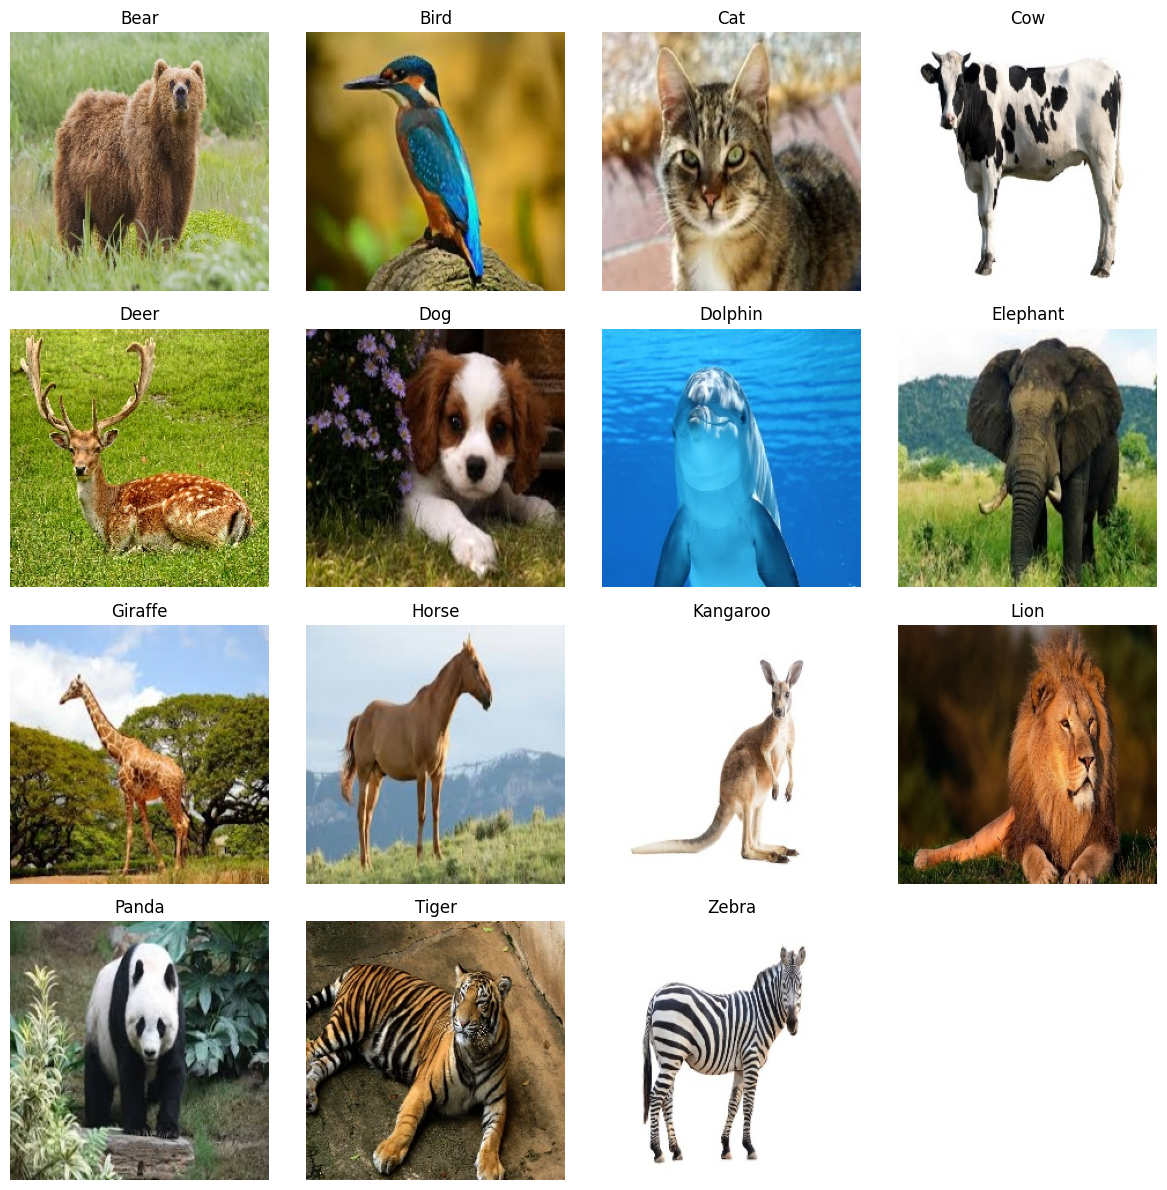

In [25]:
# Visualize one sample image from each class for initial inspection
if os.path.exists(DATA_DIR):
    plt.figure(figsize=(12, 12))
    for i, class_name in enumerate(class_names):
        ax = plt.subplot(4, 4, i + 1)
        class_dir = os.path.join(DATA_DIR, class_name)
        first_image_path = os.path.join(class_dir, os.listdir(class_dir)[0])
        img = keras.utils.load_img(first_image_path, target_size=(224, 224))
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    # Hide unused subplots if there are fewer than 16 classes
    if num_classes < 16 and 'ax' in locals():
        if i + 2 <= 16:
            plt.subplot(4, 4, i + 2).set_visible(False)
    plt.tight_layout()
    plt.show()

Check Class Distribution

--- Image Count per Class ---
- Bear: 125 images
- Bird: 137 images
- Cat: 123 images
- Cow: 131 images
- Deer: 127 images
- Dog: 122 images
- Dolphin: 129 images
- Elephant: 133 images
- Giraffe: 129 images
- Horse: 130 images
- Kangaroo: 126 images
- Lion: 131 images
- Panda: 135 images
- Tiger: 129 images
- Zebra: 137 images


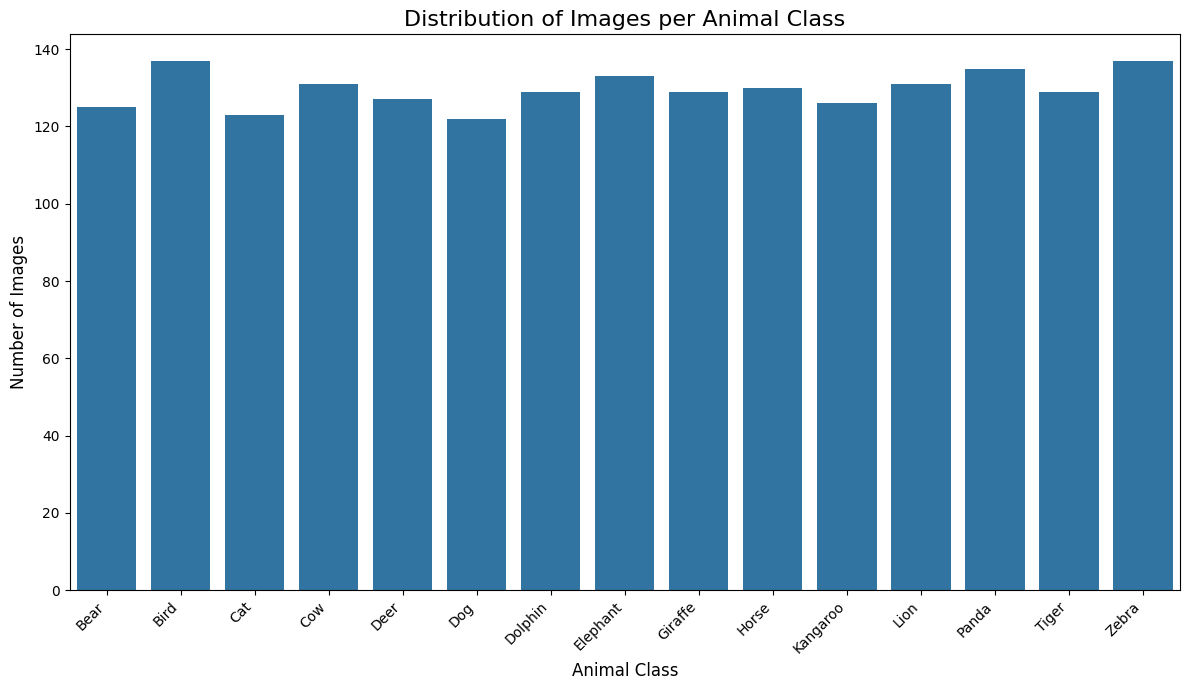

In [26]:
# Count the number of images in each class and visualize the class distribution
if os.path.exists(DATA_DIR):
    image_counts = {}
    for class_name in class_names:
        class_dir = os.path.join(DATA_DIR, class_name)
        image_counts[class_name] = len(os.listdir(class_dir))

    print("--- Image Count per Class ---")
    for name, count in image_counts.items():
        print(f"- {name}: {count} images")

    plt.figure(figsize=(12, 7))
    sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
    plt.title('Distribution of Images per Animal Class', fontsize=16)
    plt.xlabel('Animal Class', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Create Data Generators & Split Data

In [27]:
# Define image size and batch size for model input and training
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create TensorFlow datasets from the directory structure
full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Split the dataset into training, validation, and test sets
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size).take(val_size)
test_dataset = full_dataset.skip(train_size + val_size).take(test_size)

print(f"Total batches in the full dataset: {dataset_size}")
print(f"Number of batches for Training: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Number of batches for Validation: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Number of batches for Testing: {tf.data.experimental.cardinality(test_dataset).numpy()}")

# Optimize dataset loading performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 1944 files belonging to 15 classes.
Total batches in the full dataset: 61
Number of batches for Training: 48
Number of batches for Validation: 6
Number of batches for Testing: 7


Set Up Data Augmentation

In [ ]:
# Create a data augmentation layer to improve model generalization
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2),
], name="data_augmentation")

Build the Transfer Learning Model

In [ ]:
# Build the transfer learning model using EfficientNetB0 as the base
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

# Set model parameters
INPUT_SHAPE = IMG_SIZE + (3,)
BASE_MODEL_TRAINABLE = False

# Define the model architecture
inputs = Input(shape=INPUT_SHAPE, name="input_layer")
x = data_augmentation(inputs)
base_model = EfficientNetB0(include_top=False,
                            weights='imagenet',
                            input_tensor=None,
                            input_shape=INPUT_SHAPE)
base_model.trainable = BASE_MODEL_TRAINABLE
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = Dense(num_classes, activation="softmax", name="output_layer")(x)
model = Model(inputs, outputs, name="Animal_Classifier_EfficientNetB0")

# Compile the model for initial training
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("--- Model Architecture Summary ---")
model.summary()

16719872/16705208 [==============================] - 3s 0us/step
--- Model Architecture Summary ---
Model: "Animal_Classifier_EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 15)                19215     


Model Training (Initial & Fine-Tuning)

In [ ]:
# Train the model with the base model frozen (initial training)
print("--- Starting Initial Training (Training the Head) ---")

# Callback to save the best model weights during training
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="initial_checkpoint.h5",
    save_weights_only=True,
    save_best_only=True,
    monitor="val_accuracy"
)

INITIAL_EPOCHS = 10

# Fit the model on the training data and validate on the validation set
history = model.fit(
    train_dataset,
    epochs=INITIAL_EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
)

print("--- Initial Training Complete ---")

--- Starting Initial Training (Training the Head) ---
Epoch 1/10
48/48 [==============================] - 45s 857ms/step - loss: 1.7813 - accuracy: 0.5664 - val_loss: 0.9219 - val_accuracy: 0.8646
Epoch 2/10
48/48 [==============================] - 43s 901ms/step - loss: 0.8746 - accuracy: 0.8249 - val_loss: 0.5428 - val_accuracy: 0.9010
Epoch 3/10
48/48 [==============================] - 42s 866ms/step - loss: 0.6400 - accuracy: 0.8743 - val_loss: 0.4325 - val_accuracy: 0.9219
Epoch 4/10
48/48 [==============================] - 41s 849ms/step - loss: 0.5622 - accuracy: 0.8646 - val_loss: 0.3604 - val_accuracy: 0.9323
Epoch 5/10
48/48 [==============================] - 41s 861ms/step - loss: 0.4748 - accuracy: 0.8887 - val_loss: 0.2996 - val_accuracy: 0.9479
Epoch 6/10
48/48 [==============================] - 39s 807ms/step - loss: 0.4317 - accuracy: 0.9036 - val_loss: 0.2348 - val_accuracy: 0.9635
Epoch 7/10
48/48 [==============================] - 39s 811ms/step - loss: 0.3978 - accu

Visualize Initial Training Results

--- Visualizing Initial Training Performance ---


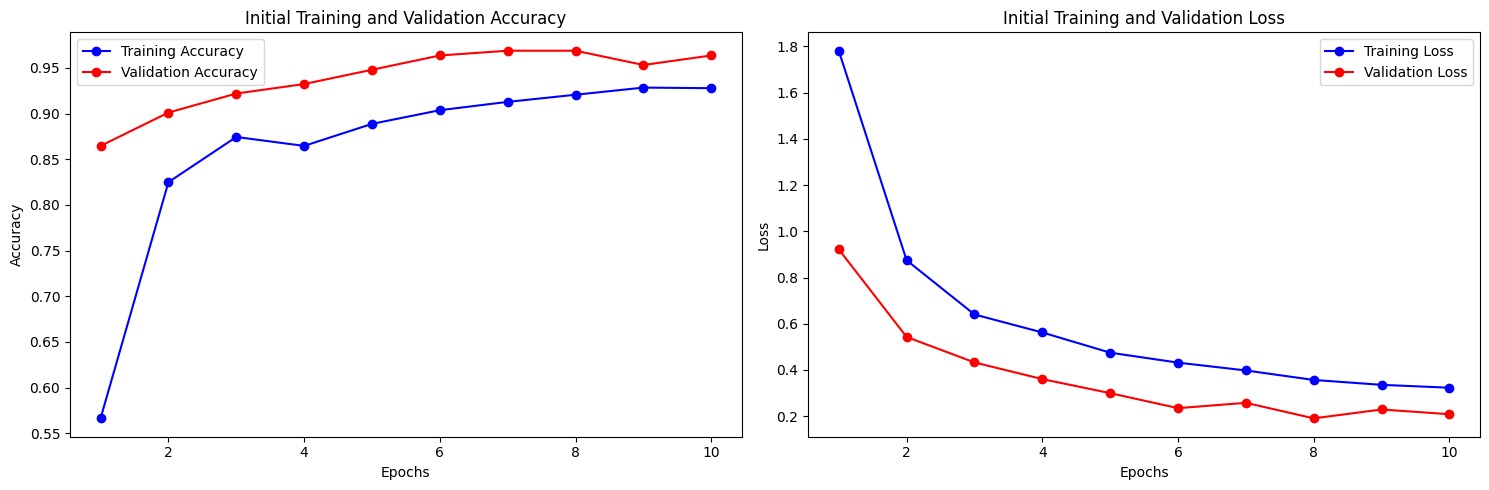

In [ ]:
# Plot training and validation accuracy and loss curves
def plot_history(history, title_prefix):
    """Plot accuracy and loss curves for training and validation."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{title_prefix} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title_prefix} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("--- Visualizing Initial Training Performance ---")
plot_history(history, "Initial")

 Fine-Tuning the Model

In [ ]:
# Unfreeze the base model and fine-tune selected layers
base_model.trainable = True

# Display the number of layers in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")

# Freeze the first 100 layers to preserve pre-trained features
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n--- Model Re-compiled for Fine-Tuning ---")
model.summary()

# Continue training with fine-tuning
print("\n--- Starting Fine-Tuning ---")
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

history_fine_tune = model.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=val_dataset
)

print("--- Fine-Tuning Complete ---")

Number of layers in the base model: 237

--- Model Re-compiled for Fine-Tuning ---
Model: "Animal_Classifier_EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 15)                19215     
                 

Visualize Fine-Tuning Results


--- Visualizing Overall Training Performance (Initial + Fine-Tuning) ---


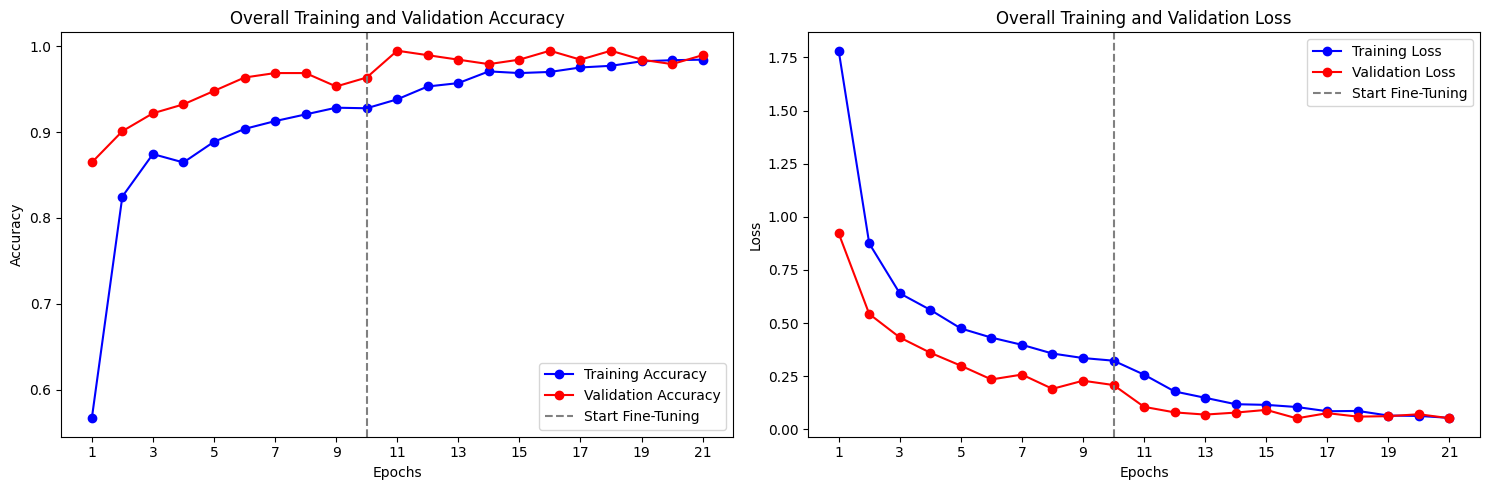

In [ ]:
# Combine initial and fine-tuning training histories for visualization
def combine_histories(initial_history, fine_tune_history):
    """Combine training and validation metrics from both training phases."""
    acc = initial_history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = initial_history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = initial_history.history['loss'] + fine_tune_history.history['loss']
    val_loss = initial_history.history['val_loss'] + fine_tune_history.history['val_loss']
    return acc, val_acc, loss, val_loss

print("\n--- Visualizing Overall Training Performance (Initial + Fine-Tuning) ---")
acc, val_acc, loss, val_loss = combine_histories(history, history_fine_tune)
total_epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(total_epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(total_epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.axvline(len(history.history['accuracy']) - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Overall Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(np.arange(0, len(acc), step=2), np.arange(1, len(acc)+1, step=2))

plt.subplot(1, 2, 2)
plt.plot(total_epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(total_epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.axvline(len(history.history['accuracy']) - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Overall Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(0, len(acc), step=2), np.arange(1, len(acc)+1, step=2))

plt.tight_layout()
plt.show()

Evaluate the Model on the Test Set

In [ ]:
# Evaluate the final model on the test set and display performance metrics
from sklearn.metrics import classification_report, confusion_matrix

print("--- Evaluating Final Model on Unseen Test Data ---")
results = model.evaluate(test_dataset)

print("\n--- Test Set Performance ---")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")

# Generate predictions and true labels for detailed evaluation
y_true = []
y_pred_probs = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images, verbose=0))

y_pred = np.argmax(y_pred_probs, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

--- Evaluating Final Model on Unseen Test Data ---
7/7 [==============================] - 5s 586ms/step - loss: 0.0694 - accuracy: 0.9815

--- Test Set Performance ---
Test Loss: 0.0694
Test Accuracy: 0.9815 (98.15%)

--- Classification Report ---
              precision    recall  f1-score   support

        Bear       0.92      1.00      0.96        11
        Bird       1.00      1.00      1.00        15
         Cat       1.00      1.00      1.00        11
         Cow       1.00      0.93      0.96        14
        Deer       1.00      0.93      0.97        15
         Dog       1.00      1.00      1.00        16
     Dolphin       1.00      0.94      0.97        17
    Elephant       0.94      1.00      0.97        15
     Giraffe       1.00      1.00      1.00        15
       Horse       1.00      1.00      1.00        11
    Kangaroo       0.94      1.00      0.97        16
        Lion       1.00      1.00      1.00        17
       Panda       1.00      1.00      1.00      

Visualize the Confusion Matrix

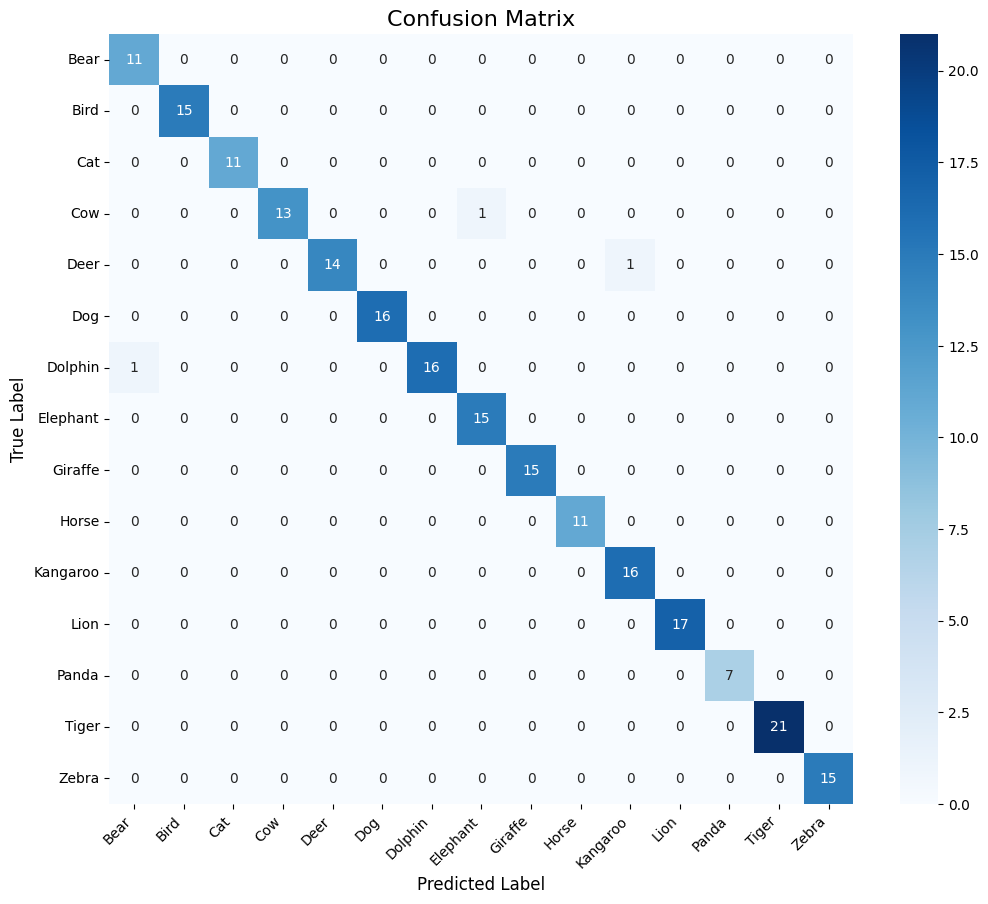

In [ ]:
# Generate and plot the confusion matrix for test set predictions
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', # Display integer counts
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()